In [18]:
####################################################
# This is a scratchpad for analysis of intermediate results in the CGMBrush library.
####################################################

# NOTE: Always clear results before checking in a jupyter notebook. This improves diff's.
%load_ext autoreload
%autoreload 2
from cgmbrush.cgmbrush import *
from cgmbrush.plots.plots import *
import matplotlib.colors as colors
from cgmbrush.cosmology import cosmology as cosmo
from cgmbrush.cosmology import halo as halo
import numpy as np

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


cellsize (kpc): 21.798270089285715
co-moving virial radius (kpc): 329.5198870049056
cellsize (kpc): 21.798270089285715
co-moving virial radius (kpc): 329.5198870049056
cellsize (kpc): 21.798270089285715
co-moving virial radius (kpc): 329.5198870049056


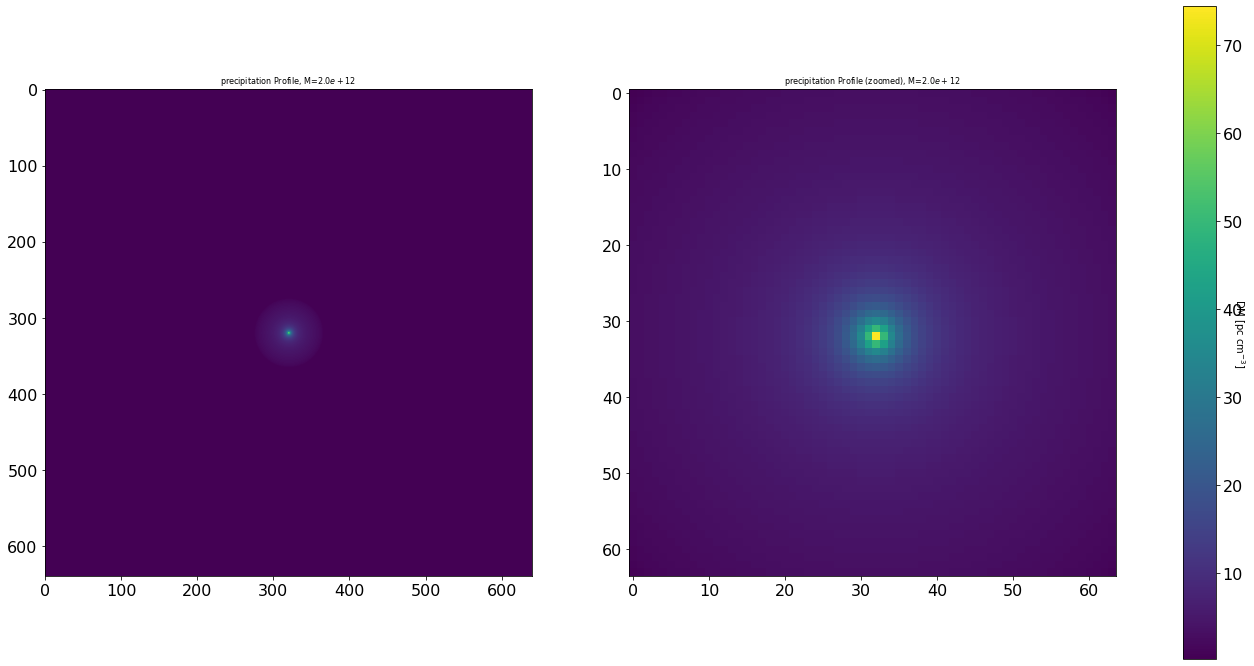

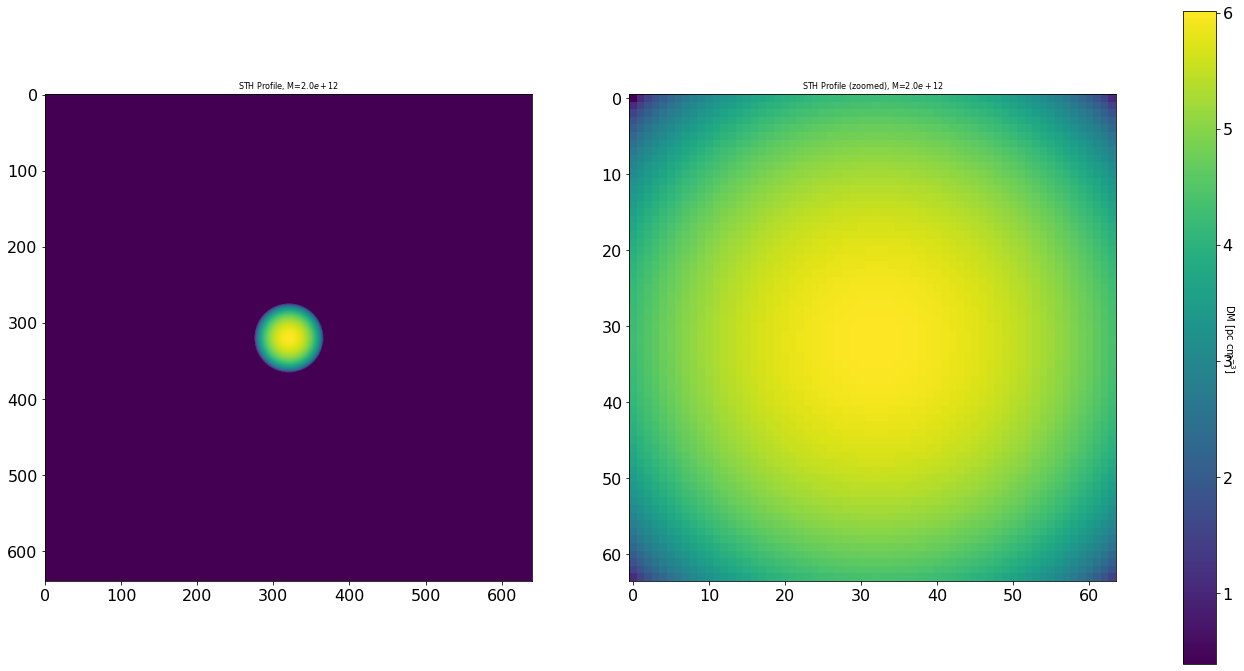

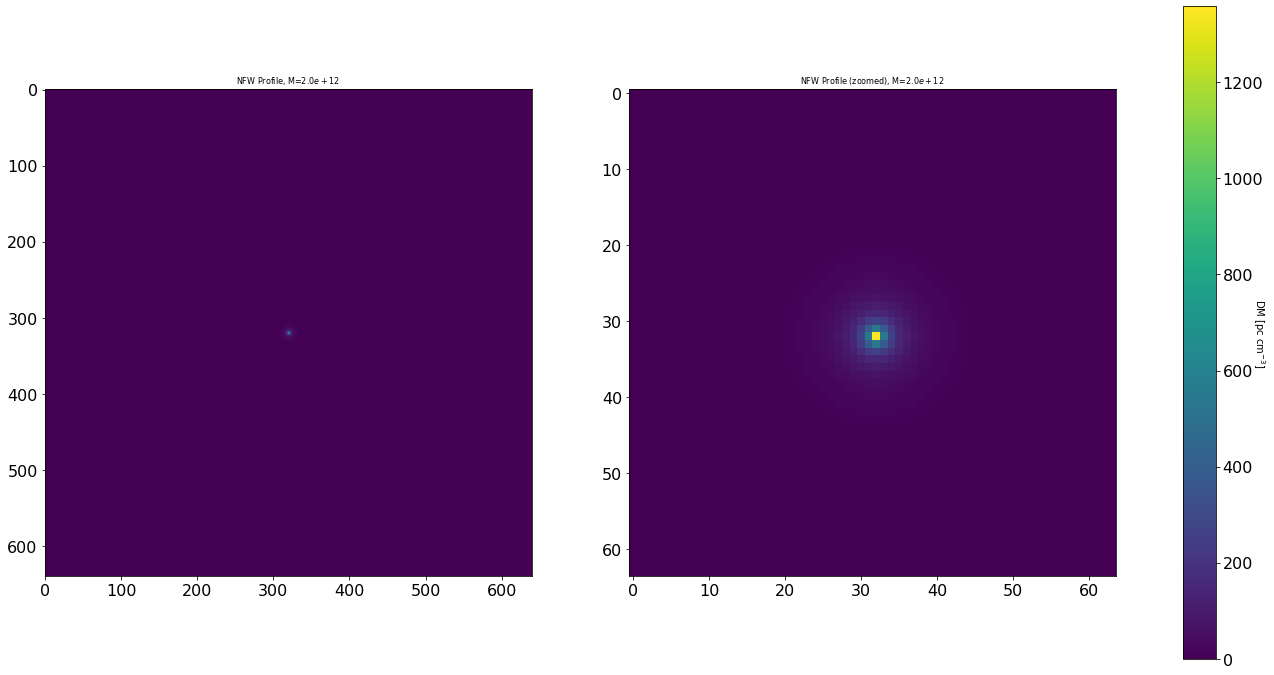

In [19]:
###################################################
# Profile Mask Visualizer
###################################################

# Choose a profile and mass
# Colorbar will be in units of in DM [pc cm^3]
view_mask(PrecipitationProfile(), 2E12) 
view_mask(SphericalTophatProfile(rvir_factor=3), 2E12) 
view_mask(NFWProfile(), 2E12) 

In [ ]:
from cgmbrush import *
def compareRadii(mass, z):
    print("Mass {:.1e}, z={}".format(mass, z))
    a = halo.comoving_rvir(cosmo, mass, z)
    b = halo.r200Mz(cosmo, mass, z)
    print('  rVir:\t{:.4f} Mpc'.format(a))
    print('  r200:\t{:.4f} Mpc'.format(b))
    print('  difference:\t{:.1f}%'.format((abs(b-a)) * 100 / b))

masses = [1E10,1E13,1E15]
redshifts = [0,0.5,1,2]

for z in redshifts:
    for m in masses:
        compareRadii(m, z)

In [ ]:
####################################################
# Get a feel for halo masses for the simulation
####################################################
p = BolshoiProvider()
halos = p.get_halos(0)
print('Max: {:.2e}'.format(max(halos['Mvir'])))
print(np.percentile(halos['Mvir'], [50,80,95,99,99.9,99.99,99.999]))

Mvir_avg = []
haloArray, bin_markers = create_halo_array_for_convolution(halos,DEFAULT_MIN_MASS,DEFAULT_MAX_MASS,DEFAULT_MASS_BIN_COUNT)
for j in range(0,len(bin_markers)-1):
    Mvir_avg.append((np.mean((haloArray['Mvir'][bin_markers[j]:bin_markers[j+1]])) / cosmo.h, bin_markers[j+1]-bin_markers[j]))

for i in Mvir_avg:
    print("{:.1e}, {}".format(i[0], i[1]))


In [ ]:
###################################################################################################
#Simplified code that calculates the mass within the analytic profile 
#Currently it does this for fire and percipitation but can be easily generalized
#
#The vertical lines are the virial radius
###################################################################################################

redshift = 0
#df = provider.get_halos(redshift)
#df, bin_markers = create_halo_array_for_convolution(df, 10**10, 9*10**15, 30)

massfactor =   1/cosmo.fb*mu*mprot/msun*(Mpc)**3

fp = FireProfile()
percip = PrecipitationProfile()
color = ['black','red', 'orange', 'blue', 'green', 'cyan', 'magenta', 'yellow', 'brown']
nummass=6
i=0
for Mvir_avg in np.logspace(10, 15, nummass):

    rvir = halo.comoving_rvir(cosmo, Mvir_avg, redshift)
    #rvalsFire, densityFire = fp.get_analytic_profile(Mvir_avg, redshift)
    rvalsPercip, densityPercip = percip.get_analytic_profile(Mvir_avg, redshift)


    #totalmassanalyticFire = 4.*np.pi*np.sum(rvalsFire[1:]**2*densityFire[1:] *(rvalsFire[1:] - rvalsFire[:-1]))
    totalmassanalyticPercip = 4.*np.pi*np.sum(rvalsPercip[1:]**2*densityPercip[1:]*(rvalsPercip[1:] - rvalsPercip[:-1]))
    
    #totalmassanalyticFire *= massfactor
    totalmassanalyticPercip *= massfactor
    #print(np.log10(Mvir_avg), "massFire in 1e12 = ", totalmassanalyticFire/1e12, " truth = ", Mvir_avg/1e12, " ratio =", totalmassanalyticFire/Mvir_avg)
    print(np.log10(Mvir_avg), "massPercip in 1e12 = ", totalmassanalyticPercip/1e12,  " truth = ",  Mvir_avg/1e12,  " ratio =", totalmassanalyticPercip/Mvir_avg)
    

    #plt.loglog(rvalsFire, densityFire, color=color[i%nummass])
    plt.loglog(rvalsPercip, densityPercip, '--', color=color[i%nummass])
    plt.axvline(rvir, color=color[i%nummass])
    i+=1
        

plt.xlim([.01,3])

In [ ]:
# Analyze where mass is going in Precipitation Profile

redshift = 0
massfactor =  1/cosmo.fb*mu*mprot/msun*(Mpc)**3
p = PrecipitationProfile()
p.debug=True

Mvir = np.logspace(np.log10(DEFAULT_MIN_MASS),np.log10(DEFAULT_MAX_MASS), DEFAULT_MASS_BIN_COUNT)

for m in Mvir:

    rvir_kpc = 1000*halo.comoving_rvir(cosmo, m, redshift) # comoving radius

    print("Mass  {:.1e}".format(m))
    n1, n2, xi1, xi2, neconstant, XRvir, rmax = p.get_precipitation_params(np.log10(m), rvir_kpc, redshift, True)
    # A 3Rvir tophat puts 1/27 of the tophat mass into the 1Rvir. 
    # So 0.037 + what is reported as being in power law is total within 1 Rvir.

    # More details in needed
    #print("3Rvir {:.1f}kpc".format(3*rvir_kpc))
    #print("rmax  {:.1f} kpc".format(rmax))
    #print(" n1 = {:.1e} cm^-3; n2 = {:.1e} cm^-3".format(n1,n2))


In [ ]:
# Mass Bin Analysis
a = np.logspace(np.log10(DEFAULT_MIN_MASS),np.log10(DEFAULT_MAX_MASS), DEFAULT_MASS_BIN_COUNT)
print(a)
#delta = 1.21164168


In [ ]:
# Look at radial values (in kpc) for a DM vs R profile you've already made
provider = BolshoiProvider()
res = 32
date = '2022-06-03'
grid_size = 1024 * res
mass_bin_to_print = 45
DM_vs_R_total = loadArray('precipitation_and_NFW_13.3{}_512_{}_DMvsR_prof'.format(res, date))            
DM_vs_R_mask_only = loadArray('precipitation_and_NFW_13.3{}_512_{}_masks'.format(res, date))            

cellsize = (provider.Lbox/grid_size) 
x_axis = radial_distances_kpc(cellsize, DM_vs_R_total.shape[1])
saveArray('radial_distance_kpc_res32k', x_axis)
with np.printoptions(precision=1, linewidth=1000, threshold=sys.maxsize):
    print("The radial distances (in kpc) corresponding to each point int he DM vs R array.")
    print(x_axis) # 
    print("\nTotal DM radial profile (includes mean DM of ~81)")
    print(DM_vs_R_total[mass_bin_to_print]) # 
    print("\nApplied DM radial profile")
    print(DM_vs_R_mask_only[mass_bin_to_print]) # 

In [ ]:

# # Run a config, generate DM vs R, visualize radial profiles for analysis
provider = BolshoiProvider()
series = []
resolution = 8
grid_size = provider.halofieldresolution*resolution
load = True
date = '2022-06-04'
RS_values = RS_array_gen(1,provider.Lbox)
z = RS_values[7]

config = Configuration(PrecipitationProfile(), provider=provider, resolution=resolution, RS_array=[z], den_grid_size=256, datestamp=date)
config.run(load_from_files=load)
config.generate_DM_vs_radius_profile(load_from_files=load)
config.generate_profile_of_masks(load_from_files=load)
series.append((config.DM_vs_R1, config.mask_profiles, 'Precip z={:.1f}'.format(z), 'c', '-'))

config = Configuration(NFWProfile(), provider=provider, resolution=resolution, RS_array=[z], den_grid_size=256, datestamp=date)
config.run(load_from_files=load)
config.generate_DM_vs_radius_profile(load_from_files=load)
config.generate_profile_of_masks(load_from_files=load)
series.append((config.DM_vs_R1, config.mask_profiles, 'NFW', 'b', '-'))

#config = Configuration(SphericalTophatProfile(rvir_factor=3), provider=provider, resolution=resolution, den_grid_size=256, datestamp=date)
#config.run(load_from_files=load)
#config.generate_DM_vs_radius_profile(load_from_files=load)
#config.generate_profile_of_masks(load_from_files=load)
#series.append((config.DM_vs_R1, config.mask_profiles, 'STH 3', 'y', '-'))

vir_rad_ar = config.get_virial_radii()
avg_mass_ar = config.get_halo_masses()

M_chosen = range(0, 60, 1) # plot every 3rd mass bin to see evolution
ymax = (np.arange(0, 60, 1) ** 2) + 40 # Tweak these to scale the y axis as needed
xmin = 5
xmax = 2399
make_DM_vs_Rad_profiles_plots(series, False, True, xmin, xmax, resolution, grid_size, M_chosen, vir_rad_ar, provider, avg_mass_ar, ymax, 'temp_analysis')
